# Forecasting Store Sales: Analyzing Factors Impacting Favorita's Grocery Retail Unit Sales

## Business Understanding

### Business Background:
Corporation Favorita stands as a prominent Ecuadorian-based grocery retailer with a vast array of stores and diverse product offerings. The company's success hinges on understanding and predicting unit sales across its stores, vital for inventory management, marketing strategies, and overall business growth.

### Business Objective:
The primary objective of this analysis is to develop an accurate model for predicting unit sales of various items sold at Favorita's stores. Leveraging historical sales data, supplementary information, and extractable features, the aim is to uncover patterns, factors, and trends influencing sales. This knowledge will empower Favorita to optimize inventory, plan promotions effectively, and enhance overall sales performance.

### Hypothesis:

Null Hypothesis:
There is no significant impact in store sales during promotional periods 

Alternative Hypothesis:
There is significant impact in store sales during promotional periods 
 
### Questions
1.	What are the top 10 stores in terms of sales?
2.	What are the top 5 most frequently purchased product families?
3.	Which dates have the lowest and highest sales for each year?
4.	Did the 2016 earthquake have a noticeable impact on sales?
5.	Is there a noticeable correlation between promotions and sales?

This analysis aims to provide Favorita with actionable insights, enabling informed decision-making regarding inventory management, marketing strategies, and overall business growth, ultimately leading to optimized sales performance and customer satisfaction.



## Importing Libraries

In [1]:
! pip install pyodbc
! pip install python-dotenv
! pip install catboost
! pip install xgboost


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries for data handling 
import pyodbc
import pandas as pd
import numpy as np
from dotenv import dotenv_values

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 

# Hypothesis Testing
import scipy.stats as stats

from statsmodels.tsa.stattools import kpss
from sklearn.model_selection import train_test_split

# Feature Processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.api import AutoReg
from sklearn.model_selection import RandomizedSearchCV
import pickle



## Data Loading
## SQL Tables

In [3]:
#PULLING VARIABLES from an environment
environment_variables = dotenv_values('.env')
 
database = environment_variables.get("database_name")
server = environment_variables.get("server_name")
username = environment_variables.get("user")
password = environment_variables.get("password")
 
# defining a connection string for connecting to our SQL server datatbase
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"
 
# establish a database connection using the 'pyodbc' library
connection = pyodbc.connect(connection_string)

### Oil Table

In [4]:
query1 = 'SELECT * FROM dbo.oil'

oil_df = pd.read_sql(query1,connection)
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


### Holiday Table

In [5]:
query2 = 'SELECT * FROM dbo.holidays_events'

holiday_df = pd.read_sql(query2,connection)
holiday_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


### Stores Table

In [6]:
query3 = 'SELECT * FROM dbo.stores'

stores_df = pd.read_sql(query3,connection)
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


## CSV Dataset

### Transaction Dataset

In [7]:
#loading transaction dataset
transactions_df = pd.read_csv('transactions.csv')
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


### Train Dataset

In [8]:
#loading train dataset
train_df = pd.read_csv('train.csv')
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


### Test Dataset

In [9]:
#loading test dataset
test_df = pd.read_csv('test.csv')
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


## Data Preparation

In [10]:
# checking the .info() for the oil dataset
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


Findings: 

1. There are 2 columns and 1218 rows
2. There are possible null values
3. The date column has wrong datatype "object"
4. The column 'dcoilwtico' stands for "Daily Crude Oil 'West Texas Intermediate (WTI)' Price"
    

In [11]:
# Convert 'date' column to datetime data type
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Verify
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [12]:
#checking the sum of null values
oil_df.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [13]:
# Check the type of missing values
# Create boolean masks for rows with missing values
dcoilwtico_missing_values = oil_df['dcoilwtico'].isna()

# Use the masks to filter the DataFrame
rows_with_dcoilwtico_missing_values = oil_df[dcoilwtico_missing_values]

# Display the resulting DataFrames
print("\nRows with missing 'dcoilwtico' values:")
print(rows_with_dcoilwtico_missing_values)


Rows with missing 'dcoilwtico' values:
           date  dcoilwtico
0    2013-01-01         NaN
14   2013-01-21         NaN
34   2013-02-18         NaN
63   2013-03-29         NaN
104  2013-05-27         NaN
132  2013-07-04         NaN
174  2013-09-02         NaN
237  2013-11-28         NaN
256  2013-12-25         NaN
261  2014-01-01         NaN
274  2014-01-20         NaN
294  2014-02-17         NaN
338  2014-04-18         NaN
364  2014-05-26         NaN
393  2014-07-04         NaN
434  2014-09-01         NaN
497  2014-11-27         NaN
517  2014-12-25         NaN
522  2015-01-01         NaN
534  2015-01-19         NaN
554  2015-02-16         NaN
588  2015-04-03         NaN
624  2015-05-25         NaN
653  2015-07-03         NaN
699  2015-09-07         NaN
757  2015-11-26         NaN
778  2015-12-25         NaN
783  2016-01-01         NaN
794  2016-01-18         NaN
814  2016-02-15         NaN
843  2016-03-25         NaN
889  2016-05-30         NaN
914  2016-07-04         NaN
959  201

* Findings: The null values are of the type 'Nan'

In [14]:
# Fill missing values using forward-fill method
oil_df.fillna(method='ffill', inplace=True)

# Verify if there are any missing values after filling
oil_df.isnull().sum()

date          0
dcoilwtico    1
dtype: int64

In [15]:
# Display the first few rows of oil_df
print(oil_df.head())

# Display the last few rows of oil_df
print(oil_df.tail())

        date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02   93.139999
2 2013-01-03   92.970001
3 2013-01-04   93.120003
4 2013-01-07   93.199997
           date  dcoilwtico
1213 2017-08-25   47.650002
1214 2017-08-28   46.400002
1215 2017-08-29   46.459999
1216 2017-08-30   45.959999
1217 2017-08-31   47.259998


Note: 
The initial row of the table contains the missing value, which is why the forward-fill method was ineffective. Therefore, a backfill approach would be more suitable in this case.

In [16]:
# Fill missing values using backward-fill method
oil_df.fillna(method='bfill', inplace=True)

# Verify if there are any missing values after filling
print(oil_df.isnull().sum())

date          0
dcoilwtico    0
dtype: int64


In [17]:
# check for duplicates
dup = oil_df.duplicated().sum()
print(f'This dataset has',dup,'duplicates')

This dataset has 0 duplicates


Summary (Oil_df):

1) Convert the data type of the 'date' column from 'object' to datetime format.

2) The dataset contained 43 missing values of the type 'NaN' in the 'dcoilwtico' column

3) Addressed missing values in the 'dcoilwtico' column using the forward-fill method to carry forward the last valid observation and the backward-fill method to propagate values from the initial row.

4) Conducted a check for duplicate rows and confirmed that none were present.

In [18]:
# checking the .info() for the holiday dataset
holiday_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


Findings: 

1. There are 6 columns and 350 rows
2. There are no null values
3. The date column has wrong datatype "object"  

In [19]:
# Convert 'date' column to datetime data type
holiday_df['date'] = pd.to_datetime(holiday_df['date'])

# Verify
holiday_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [20]:
# Rename the column 'type' to 'holiday_type' in the 'holiday_df' DataFrame for uniqueness
holiday_df.rename(columns={'type': 'holiday_type'}, inplace=True)

# verify changes
holiday_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          350 non-null    datetime64[ns]
 1   holiday_type  350 non-null    object        
 2   locale        350 non-null    object        
 3   locale_name   350 non-null    object        
 4   description   350 non-null    object        
 5   transferred   350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [21]:
# check for duplicates
dup2 = holiday_df.duplicated().sum()
print(f'This dataset has',dup2,'duplicates')

This dataset has 0 duplicates


Summary (holiday_df):

1) Convert the data type of the 'date' column from 'object' to datetime format.

2) There are no missing values in the dataset

3) Conducted a check for duplicate rows and confirmed that none were present.

In [22]:
# checking the .info() for the stores dataset
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


Findings: 

1. There are 5 columns and 54 rows
2. There are no null values

In [23]:
# Rename the column 'type' to 'holiday_type' in the 'holiday_df' DataFrame for uniqueness
stores_df.rename(columns={'type': 'stores_type'}, inplace=True)

# verify changes
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   store_nbr    54 non-null     int64 
 1   city         54 non-null     object
 2   state        54 non-null     object
 3   stores_type  54 non-null     object
 4   cluster      54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [24]:
# check for duplicates
dup3 = stores_df.duplicated().sum()
print(f'This dataset has',dup3,'duplicates')

This dataset has 0 duplicates


Summary (Stores_df):

1) Convert the data type of the 'date' column from 'object' to datetime format.

2) There are no missing values in the dataset

3) Conducted a check for duplicate rows and confirmed that none were present.

In [25]:
# viewing the transactions dataset
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


Findings: 

1. There are 3 columns and 83488 rows
2. There are no null values
3. The date column has wrong datatype "object"   

In [26]:
# Convert 'date' column to datetime data type
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

# Verify
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [27]:
# check for duplicates
dup4 = transactions_df.duplicated().sum()
print(f'This dataset has',dup4,'duplicates')

This dataset has 0 duplicates


Summary (transactions_df):

1) Convert the data type of the 'date' column from 'object' to datetime format.

2) There are no missing values in the dataset

3) Conducted a check for duplicate rows and confirmed that none were present.

In [28]:
# checking the summary of the train dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


Findings: 

1. There are 6 columns and 3,000,888 rows
2. The date column has wrong datatype "object"

In [29]:
# check for missing values
train_df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [30]:
# Convert 'date' column to datetime data type
train_df['date'] = pd.to_datetime(train_df['date'])

# Verify
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [31]:
# Create a date range from the minimum to maximum date in the dataset
full_date_range = pd.date_range(start=train_df['date'].min(), end=train_df['date'].max())

# Check for missing dates
missing_dates = full_date_range[~full_date_range.isin(train_df['date'])]

# Display the missing dates
print("Missing Dates in train_df:")
print(missing_dates)


Missing Dates in train_df:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [32]:
# Create a DataFrame with missing dates
missing_dates_df = pd.DataFrame({'date': missing_dates})

# Concatenate 'train_df' with the DataFrame containing missing dates
train_df = pd.concat([train_df, missing_dates_df], ignore_index=True)

# Sort the DataFrame by date
train_df.sort_values(by='date', inplace=True)

# Display the updated 'train_df'
print(train_df)

                id       date  store_nbr                   family    sales  \
0              0.0 2013-01-01        1.0               AUTOMOTIVE    0.000   
1194        1194.0 2013-01-01       42.0              CELEBRATION    0.000   
1193        1193.0 2013-01-01       42.0             BREAD/BAKERY    0.000   
1192        1192.0 2013-01-01       42.0                    BOOKS    0.000   
1191        1191.0 2013-01-01       42.0                BEVERAGES    0.000   
...            ...        ...        ...                      ...      ...   
2999695  2999695.0 2017-08-15       25.0                  POULTRY  172.517   
2999694  2999694.0 2017-08-15       25.0  PLAYERS AND ELECTRONICS    3.000   
2999693  2999693.0 2017-08-15       25.0             PET SUPPLIES    3.000   
2999704  2999704.0 2017-08-15       26.0                    BOOKS    0.000   
2999554  2999554.0 2017-08-15       21.0               LADIESWEAR    5.000   

         onpromotion  
0                0.0  
1194             

In [33]:
# check for duplicates
dup5 = train_df.duplicated().sum()
print(f'This dataset has',dup5,'duplicates')

This dataset has 0 duplicates


Summary (train_df):

1) conducted a check for missing values and found none in the dataset

2) Convert the data type of the 'date' column from 'object' to datetime format.

3) Checked for missing dates and added them to the dataset

4) Conducted a check for duplicate rows and confirmed that none were present.

## EDA

### Merging relevant tables (Oil, holiday, stoes and transaction) to the Train Dataset

In [34]:
# Merge oil_df
train_df = pd.merge(train_df, oil_df, on='date', how='left')

# Display the updated train_df
train_df = pd.DataFrame(train_df)
train_df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,93.139999
1,1194.0,2013-01-01,42.0,CELEBRATION,0.0,0.0,93.139999
2,1193.0,2013-01-01,42.0,BREAD/BAKERY,0.0,0.0,93.139999
3,1192.0,2013-01-01,42.0,BOOKS,0.0,0.0,93.139999
4,1191.0,2013-01-01,42.0,BEVERAGES,0.0,0.0,93.139999


In [35]:
# check for duplicates
dupx = train_df.duplicated().sum()
print(f'This dataset has',dupx,'duplicates')

This dataset has 0 duplicates


In [36]:
train_df.isnull().sum()

id                  4
date                0
store_nbr           4
family              4
sales               4
onpromotion         4
dcoilwtico     857143
dtype: int64

In [37]:
train_df.shape

(3000892, 7)

In [38]:
# Merge stores_df
train_df = pd.merge(train_df, stores_df, on='store_nbr', how='left')

# Display the updated train_df
train_df = pd.DataFrame(train_df)
train_df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,stores_type,cluster
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,93.139999,Quito,Pichincha,D,13.0
1,1194.0,2013-01-01,42.0,CELEBRATION,0.0,0.0,93.139999,Cuenca,Azuay,D,2.0
2,1193.0,2013-01-01,42.0,BREAD/BAKERY,0.0,0.0,93.139999,Cuenca,Azuay,D,2.0
3,1192.0,2013-01-01,42.0,BOOKS,0.0,0.0,93.139999,Cuenca,Azuay,D,2.0
4,1191.0,2013-01-01,42.0,BEVERAGES,0.0,0.0,93.139999,Cuenca,Azuay,D,2.0


In [39]:
# check for duplicates
dupy = train_df.duplicated().sum()
print(f'This dataset has',dupy,'duplicates')

This dataset has 0 duplicates


In [40]:
train_df.isnull().sum()

id                  4
date                0
store_nbr           4
family              4
sales               4
onpromotion         4
dcoilwtico     857143
city                4
state               4
stores_type         4
cluster             4
dtype: int64

In [41]:
train_df.shape

(3000892, 11)

In [42]:
# Merge transactions_df
train_df = pd.merge(train_df, transactions_df, on=['date', 'store_nbr'], how='left')

# Display the updated train_df
train_df = pd.DataFrame(train_df)
train_df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,stores_type,cluster,transactions
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,93.139999,Quito,Pichincha,D,13.0,NaN
1,1194.0,2013-01-01,42.0,CELEBRATION,0.0,0.0,93.139999,Cuenca,Azuay,D,2.0,NaN
2,1193.0,2013-01-01,42.0,BREAD/BAKERY,0.0,0.0,93.139999,Cuenca,Azuay,D,2.0,NaN
3,1192.0,2013-01-01,42.0,BOOKS,0.0,0.0,93.139999,Cuenca,Azuay,D,2.0,NaN
4,1191.0,2013-01-01,42.0,BEVERAGES,0.0,0.0,93.139999,Cuenca,Azuay,D,2.0,NaN


In [43]:
# check for duplicates
dupz = train_df.duplicated().sum()
print(f'This dataset has',dupz,'duplicates')

This dataset has 0 duplicates


In [44]:
train_df.isnull().sum()

id                   4
date                 0
store_nbr            4
family               4
sales                4
onpromotion          4
dcoilwtico      857143
city                 4
state                4
stores_type          4
cluster              4
transactions    245788
dtype: int64

In [45]:
train_df.shape

(3000892, 12)

In [46]:
# Merge holiday_df with a left join
train_df = pd.merge(train_df, holiday_df, on='date', how='left')

# Create a new column to indicate if a day is a holiday or not based on 'holiday_type'
train_df['is_holiday'] = train_df['holiday_type'].notnull()

# Drop unnecessary columns related to holidays
train_df.drop(['locale', 'locale_name', 'description', 'transferred'], axis=1, inplace=True)

# Display the updated train_df
train_df = pd.DataFrame(train_df)
train_df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,stores_type,cluster,transactions,holiday_type,is_holiday
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,93.139999,Quito,Pichincha,D,13.0,NaN,Holiday,True
1,1194.0,2013-01-01,42.0,CELEBRATION,0.0,0.0,93.139999,Cuenca,Azuay,D,2.0,NaN,Holiday,True
2,1193.0,2013-01-01,42.0,BREAD/BAKERY,0.0,0.0,93.139999,Cuenca,Azuay,D,2.0,NaN,Holiday,True
3,1192.0,2013-01-01,42.0,BOOKS,0.0,0.0,93.139999,Cuenca,Azuay,D,2.0,NaN,Holiday,True
4,1191.0,2013-01-01,42.0,BEVERAGES,0.0,0.0,93.139999,Cuenca,Azuay,D,2.0,NaN,Holiday,True


In [47]:
# check for duplicates
dup6 = train_df.duplicated().sum()
print(f'This dataset has',dup6,'duplicates')

This dataset has 30294 duplicates


In [48]:
# Drop duplicates
train_df = train_df.drop_duplicates()

# Verify
dup_count_after = train_df.duplicated().sum()
print(f'This dataset has {dup_count_after} duplicates.')

This dataset has 0 duplicates.


In [49]:
train_df.isnull().sum()

id                    4
date                  0
store_nbr             4
family                4
sales                 4
onpromotion           4
dcoilwtico       867835
city                  4
state                 4
stores_type           4
cluster               4
transactions     247174
holiday_type    2551824
is_holiday            0
dtype: int64

In [50]:
# Checking the shape of the data
train_df.shape

(3024058, 14)

In [51]:
# Checking the specific enteries for the is_holiday column
train_df['is_holiday'].value_counts()

is_holiday
False    2551824
True      472234
Name: count, dtype: int64

Note: The observed rise in the number of holidays is a result of the merging technique employed in this process. Specifically, the presence of multiple transactions on the same date introduces the potential for increased holiday counts and not that there were 472,234 holiday days.

In [52]:
# Check the summary of the merged dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3024058 entries, 0 to 3054351
Data columns (total 14 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            float64       
 1   date          datetime64[ns]
 2   store_nbr     float64       
 3   family        object        
 4   sales         float64       
 5   onpromotion   float64       
 6   dcoilwtico    float64       
 7   city          object        
 8   state         object        
 9   stores_type   object        
 10  cluster       float64       
 11  transactions  float64       
 12  holiday_type  object        
 13  is_holiday    bool          
dtypes: bool(1), datetime64[ns](1), float64(7), object(5)
memory usage: 325.9+ MB


In [53]:
train_df.describe().T

,count,mean,min,25%,50%,75%,max,std
id,3024054.0,1502146.218326,0.0,752449.25,1503116.5,2250219.75,3000887.0,865526.209241
date,3024058,2015-04-25 07:25:36.544338688,2013-01-01 00:00:00,2014-02-28 00:00:00,2015-04-26 00:00:00,2016-06-19 00:00:00,2017-08-15 00:00:00,NaN
store_nbr,3024054.0,27.5,1.0,14.0,27.5,41.0,54.0,15.585787
sales,3024054.0,358.7786,0.0,0.0,11.0,196.0,124717.0,1106.756572
onpromotion,3024054.0,2.610785,0.0,0.0,0.0,0.0,741.0,12.255982
dcoilwtico,2156223.0,67.838623,26.190001,46.400002,53.380001,95.779999,110.620003,25.65698
cluster,3024054.0,8.481481,1.0,4.0,8.5,13.0,17.0,4.649735
transactions,2776884.0,1697.513155,5.0,1047.0,1395.0,2083.0,8359.0,967.331106


* insights:

1. **sales:**
The 'sales' column has a mean of approximately 358.78, with a minimum of 0.0 and a maximum of 124,717.0.
The standard deviation (std) is 1106.76 and a median of 11.0 indicating a significant spread in the data, potential outliers or a highly skewed distribution and also suggesting that sales vary greatly across different observations.

2. **onpromotion:**
The 'onpromotion' column have a maximum value of 741.0, but the 75th percentile is 0.0. This suggests a highly skewed distribution, where most values are concentrated around 0 (not on promotion). This also indicates that promotions are not prevalent for a significant portion of the dataset.

3. **dcoilwtico:**
The 'dcoilwtico' column represents the daily oil prices, changes in oil prices can impact the overall economy and subsequently, consumer spending. It has a mean of approximately 67.83, with a minimum of 26.19 and a maximum of 110.62. The Standard deviation is relatively high (25.66), indicating significant variability..

4. **transactions:**
The 'transactions' column has a mean of approximately 1697.51, with a minimum of 5.0 and a maximum of 8359.0. The median (50th percentile) is 1,395, indicating a potential right-skewed distribution or outliers.

5. **cluster:**
The 'cluster' column represents the grouping of stores associated with each record, ranging from 1 to 17.
The distribution appears uniform across clusters, suggesting a diverse representation of clusters in the dataset.

6. **store_nbr:**
Represents the store ID numbers, ranging from 1 to 54.
The distribution seems uniform, indicating that the dataset covers a variety of stores.

In [54]:
# Checking the value counts of the uniques enterings in the family column
train_df['family'].value_counts()

family
AUTOMOTIVE                    91638
LIQUOR,WINE,BEER              91638
GROCERY I                     91638
GROCERY II                    91638
HARDWARE                      91638
HOME AND KITCHEN I            91638
HOME AND KITCHEN II           91638
EGGS                          91638
DELI                          91638
DAIRY                         91638
CLEANING                      91638
HOME APPLIANCES               91638
HOME CARE                     91638
LADIESWEAR                    91638
LAWN AND GARDEN               91638
LINGERIE                      91638
MAGAZINES                     91638
CELEBRATION                   91638
MEATS                         91638
PERSONAL CARE                 91638
PET SUPPLIES                  91638
PLAYERS AND ELECTRONICS       91638
POULTRY                       91638
PREPARED FOODS                91638
PRODUCE                       91638
SCHOOL AND OFFICE SUPPLIES    91638
SEAFOOD                       91638
BABY CARE            

In [55]:
# Mapping dictionary for grouping similar family items
family_mapping = {
    'PRODUCE': 'Grocery',
    'LADIESWEAR': 'Apparel',
    'BOOKS': 'Books',
    'SEAFOOD': 'Grocery',
    'EGGS': 'Dairy',
    'HOME CARE': 'Home',
    'HOME APPLIANCES': 'Home',
    'CLEANING': 'Home',
    'DAIRY': 'Dairy',
    'DELI': 'Deli',
    'AUTOMOTIVE': 'Automotive',
    'LINGERIE': 'Apparel',
    'HOME AND KITCHEN II': 'Home',
    'HOME AND KITCHEN I': 'Home',
    'HARDWARE': 'Home',
    'GROCERY II': 'Grocery',
    'GROCERY I': 'Grocery',
    'LAWN AND GARDEN': 'Home',
    'MAGAZINES': 'Books',
    'LIQUOR,WINE,BEER': 'Beverages',
    'CELEBRATION': 'Beverages',
    'MEATS': 'Deli',
    'PERSONAL CARE': 'Beauty',
    'PET SUPPLIES': 'Home',
    'PLAYERS AND ELECTRONICS': 'Electronics',
    'POULTRY': 'Deli',
    'PREPARED FOODS': 'Deli',
    'SCHOOL AND OFFICE SUPPLIES': 'Books',
    'BABY CARE': 'Baby',
    'BEAUTY': 'Beauty',
    'BEVERAGES': 'Beverages',
    'BREAD/BAKERY': 'Grocery',
    'FROZEN FOODS': 'Grocery'
}

# Create a new column 'family_group' based on the mapping
train_df['family'] = train_df['family'].map(family_mapping)

# verify changes
train_df['family'].value_counts()


family
Home           733104
Grocery        549828
Deli           366552
Beverages      274914
Books          274914
Beauty         183276
Apparel        183276
Dairy          183276
Automotive      91638
Baby            91638
Electronics     91638
Name: count, dtype: int64

### Univariate Analysis

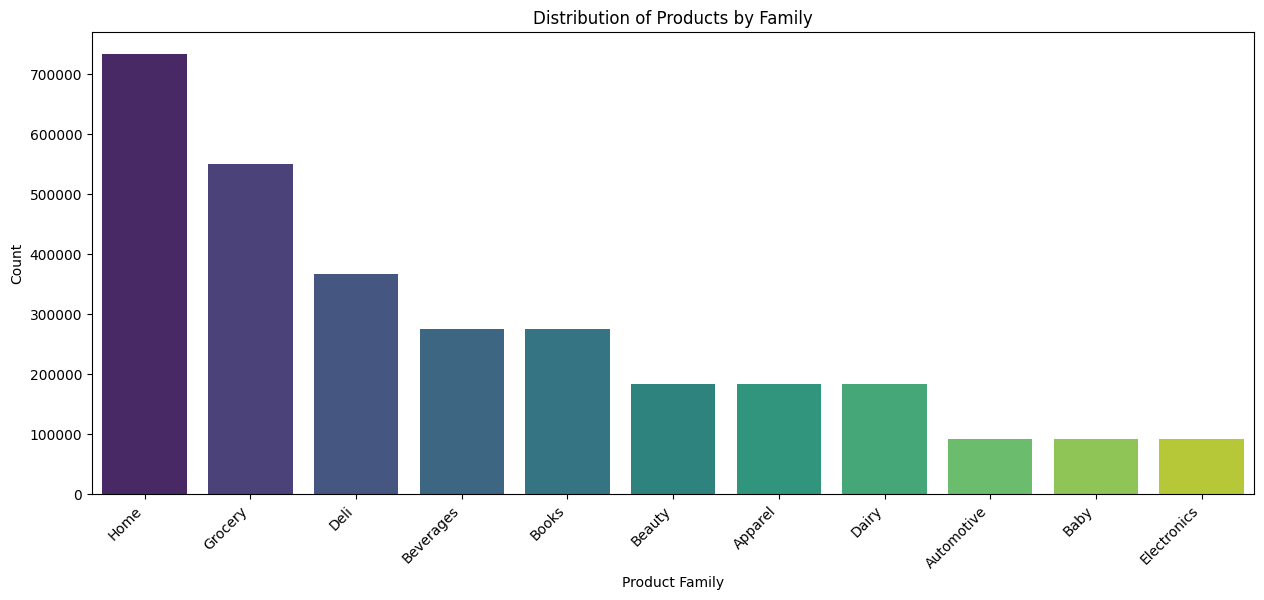

In [56]:
family_counts = train_df['family'].value_counts()

# Plotting the count of each family
plt.figure(figsize=(15, 6))
sns.barplot(x=family_counts.index, y=family_counts.values, palette='viridis')
plt.title('Distribution of Products by Family')
plt.xlabel('Product Family')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

* There are 11 unique product families with home products ranking highest.

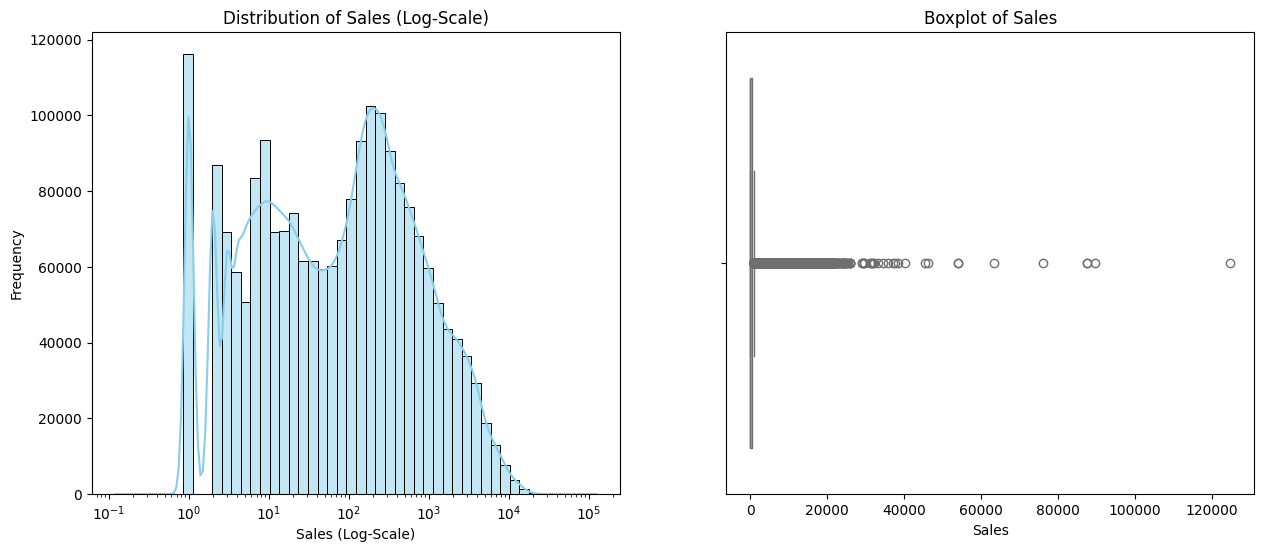

In [57]:
# Check for non-finite values in 'sales'
non_finite_sales = train_df['sales'][~np.isfinite(train_df['sales'])]

# Plotting histogram and boxplot for 'sales' with log-scale (handling non-finite values)
plt.figure(figsize=(15, 6))

# Histogram with log-scale (handling non-finite values)
plt.subplot(1, 2, 1)
sns.histplot(train_df['sales'].replace({0: np.nan}), bins=50, kde=True, color='skyblue', log_scale=True)
plt.title('Distribution of Sales (Log-Scale)')
plt.xlabel('Sales (Log-Scale)')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=train_df['sales'].replace({0: np.nan}), color='skyblue')
plt.title('Boxplot of Sales')
plt.xlabel('Sales')

plt.show()


* The sales column is highly positively skewed with most enteries clustered around zero (0) and there is presence of outliers on the right side of the distribution.

NB: In order to get better visualization, a log-scale was employed to spreading out the data and providing a clearer picture of the distribution.


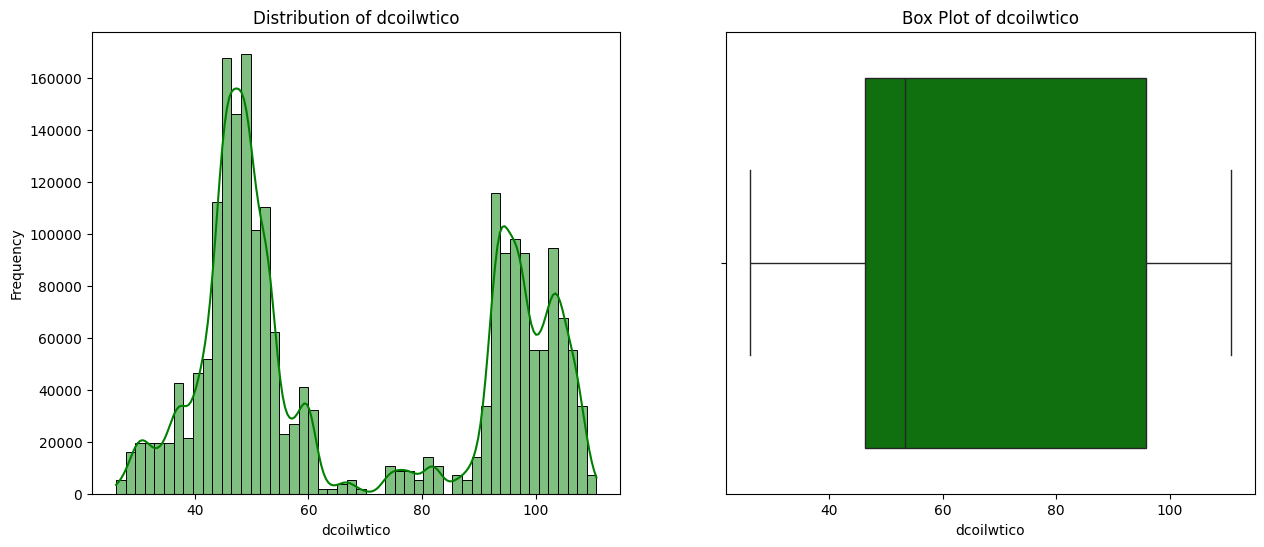

In [58]:
plt.figure(figsize=(15, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(train_df['dcoilwtico'].dropna(), bins=50, kde=True, color='green')
plt.title('Distribution of dcoilwtico')
plt.xlabel('dcoilwtico')
plt.ylabel('Frequency')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(x=train_df['dcoilwtico'].dropna(), color='green')
plt.title('Box Plot of dcoilwtico')

plt.show()

* Insight:

The 'dcoilwtico' column has bimodal distribution which is indicative of two different periods or states with distinct oil price levels.

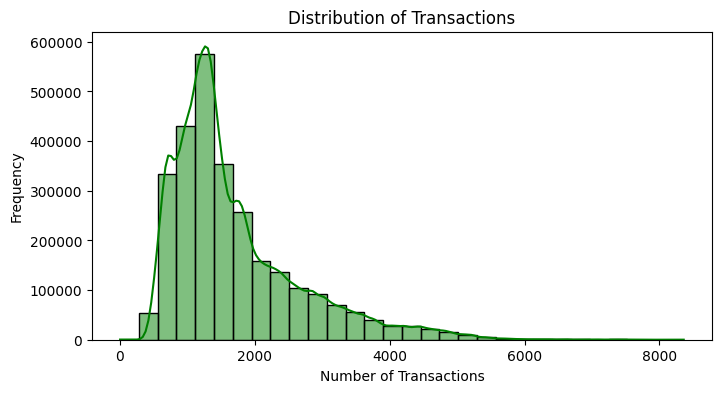


Skewness: 1.5316359226668543


In [59]:
# Visualizing the distribution
plt.figure(figsize=(8, 4))
sns.histplot(train_df['transactions'], bins=30, kde=True, color='green')
plt.title('Distribution of Transactions')
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.show()

# Skewness
skewness_transactions = train_df['transactions'].skew()
print("\nSkewness:", skewness_transactions)

* Insights:

The positively-skewed distribution suggests that a minority of stores exhibit exceptionally high transaction counts, while the majority of stores experience a lower number of transactions. This will inform the handling of NaN values

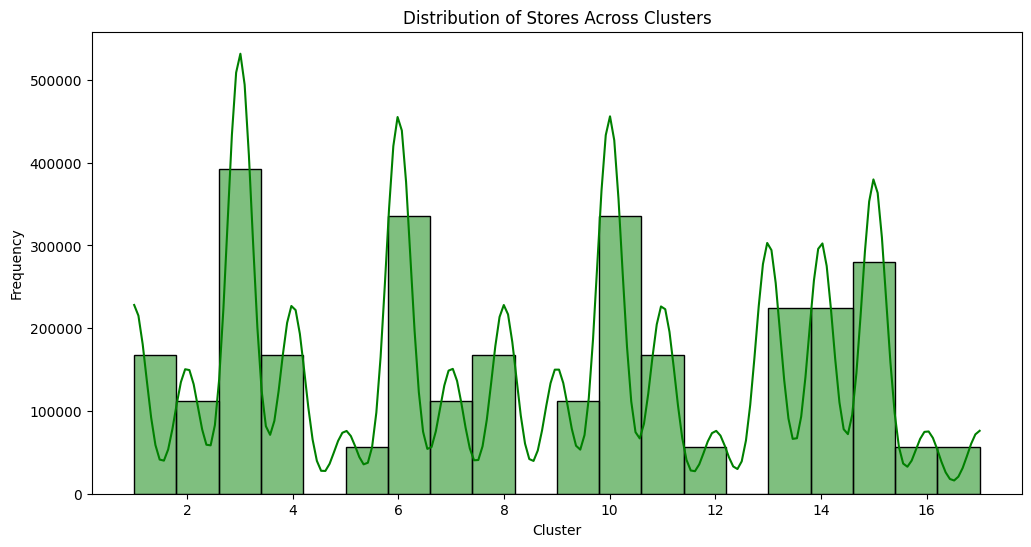

Skewness: 0.040086837183362464


In [60]:
# Univariate Analysis for the 'cluster' column
plt.figure(figsize=(12, 6))
sns.histplot(train_df['cluster'], bins=20, kde=True, color='green')
plt.title('Distribution of Stores Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()

# Skewness
cluster_skewness = train_df['cluster'].skew()
print(f"Skewness: {cluster_skewness}")

* Insight:

The distribution of stores among different clusters is well-balanced, as reflected by the skewness close to zero (0.04). This suggests that stores are evenly spread across the various clusters, contributing to a relatively uniform distribution.

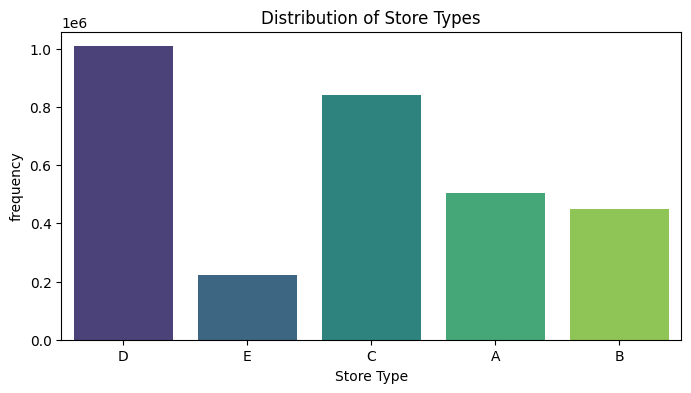

In [61]:
# Univariate analysis of the 'stores_type' column
plt.figure(figsize=(8, 4))
sns.countplot(data=train_df, x='stores_type', palette='viridis')
plt.title('Distribution of Store Types')
plt.xlabel('Store Type')
plt.ylabel('frequency')
plt.show()


* Insight:
There are five types of stores, with the D store type having the highest count. 'C' type of stores ranks next to D with E having the lowest counts.

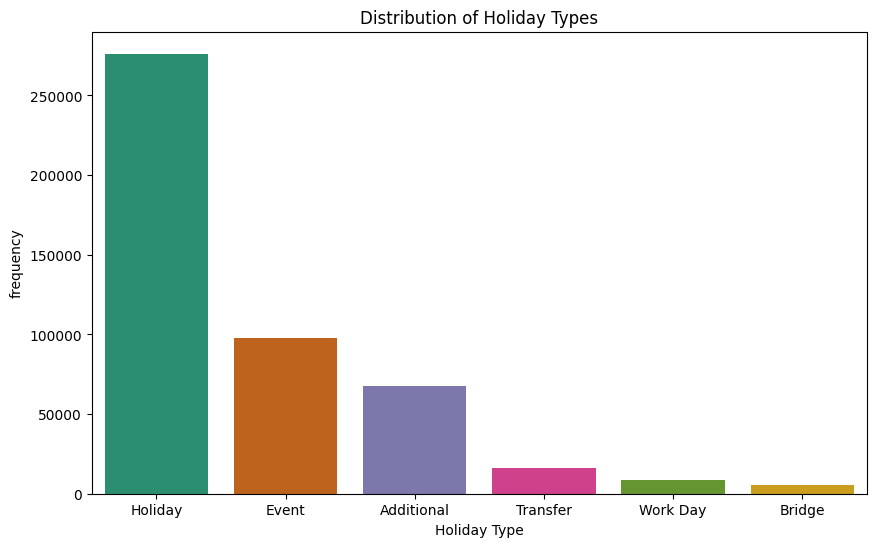

In [62]:
# Univariate Analysis for the 'holiday_type' column
# Count the occurrences of each holiday type
holiday_type_counts = train_df['holiday_type'].value_counts()

# Sorting the holiday types based on count in descending order
sorted_holiday_types = holiday_type_counts.index.tolist()

# Plotting the distribution of holiday types
plt.figure(figsize=(10, 6))
sns.countplot(x=train_df['holiday_type'], order=sorted_holiday_types, palette='Dark2')
plt.title('Distribution of Holiday Types')
plt.xlabel('Holiday Type')
plt.ylabel('frequency')
plt.show()

* Insight: The visualization indicate that "Holiday" has the highest count of transactions among holiday types, followed by "Event," "Additional," "Transfer," "Workday," and "Bridge."

In [63]:
# Univariate analysis on the 'city' column
city_counts = train_df['city'].value_counts().reset_index()
city_counts.columns = ['City', 'Store Count']

# Plotting the counts using Plotly
fig = px.bar(city_counts, x='City', y='Store Count', color='City',
             title='Distribution of Stores Across Cities',
             labels={'Store Count': 'Store Count', 'City': 'City'},
             color_discrete_sequence=px.colors.qualitative.Dark2)

fig.update_layout(xaxis_title='City', yaxis_title='Store Count')
fig.show()


* Insight:

1) Favorita has a widespread presence, with stores located in 22 cities.

2) Quito (Equador's capital) stands out as the city with the highest number of Favorita stores, reaching over a million.

3) Guayaquil follows with a substantial count of around 448 thousand stores.

4) Cuenca and Santo Domingo also has a significant presence having similar store counts of 168 thousand.

This distribution highlights the concentration of Favorita stores in major cities, with Quito leading by a substantial margin. This also reflects strategic positioning in densely populated areas. The data suggests a focus on urban markets, potentially driven by factors such as population density, economic activity, and market demand.

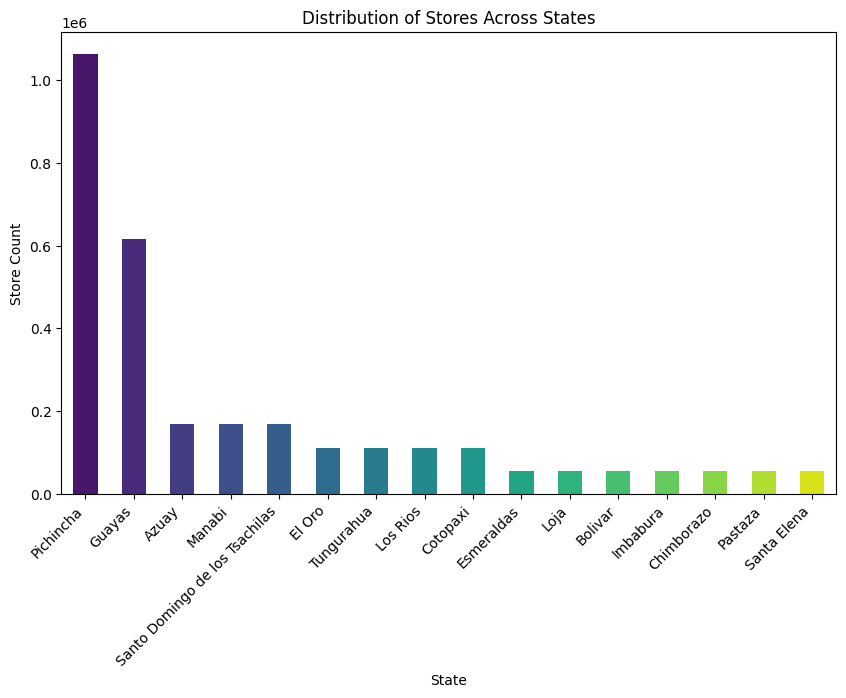

In [64]:
# Univariate analysis on the 'state' column
# Count the occurrences of each state
state_counts = train_df['state'].value_counts()

# Define a color palette
colors = sns.color_palette("viridis", len(state_counts))

# Plotting the counts
plt.figure(figsize=(10, 6))
state_counts.plot(kind='bar', color=colors)
plt.title('Distribution of Stores Across States')
plt.xlabel('State')
plt.ylabel('Store Count')
plt.xticks(rotation=45, ha='right')
plt.show()

* Insights:

1) Favorita is present in 16 states (provinces)

2) Pichincha state has the highest number of stores, indicating a concentration of stores in this particular state.

3) Guayas, Azuay, Manabi and Santo Domingo de los Tsachilas also have a significant number of stores, suggesting a relatively strong presence in these regions.

## Bivariate/Multivariate Analysis

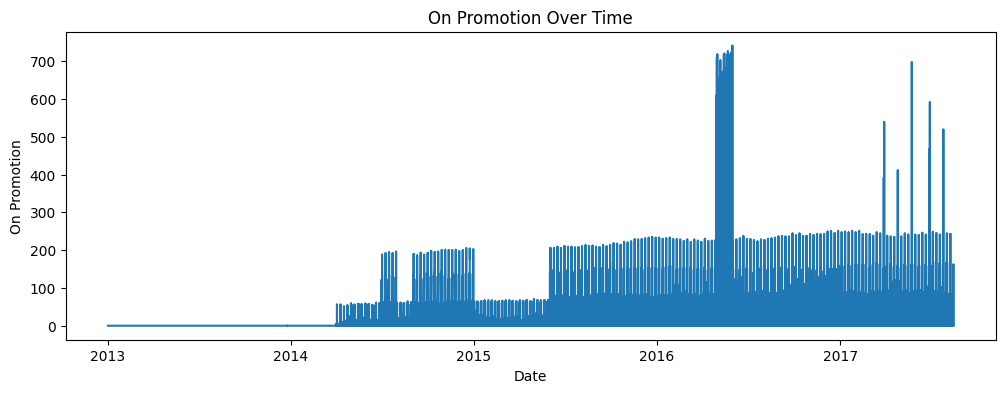

In [65]:
# Line chart for 'onpromotion'
plt.figure(figsize=(12, 4))
plt.plot(train_df['date'], train_df['onpromotion'], linestyle='-')
plt.title('On Promotion Over Time')
plt.xlabel('Date')
plt.ylabel('On Promotion')
plt.show()

NB: in order to gain more meaning of the onpromotion column, resampling was employed to aggregate the data over a specific time frequency.

In [66]:
# Resample on a monthly frequency and count the occurrences of 'onpromotion'
onpromotion_resampled = train_df.resample('M', on='date')['onpromotion'].sum().reset_index()

# Plotting with Plotly
fig = px.line(onpromotion_resampled, x='date', y='onpromotion', title='On Promotion Over Time (Monthly Resampled)',
              labels={'onpromotion': 'Count'}, line_shape='linear')

fig.update_xaxes(title_text='Date', showgrid=False)
fig.update_yaxes(title_text='Count', showgrid=False)

# Add a range slider
fig.update_layout(xaxis_rangeslider_visible=True)

fig.show()


In [67]:
# Resample on a daily frequency and count the occurrences of 'onpromotion'
onpromotion_resampled = train_df.resample('D', on='date')['onpromotion'].sum().reset_index()

# Plotting with Plotly
fig = px.line(onpromotion_resampled, x='date', y='onpromotion', title='On Promotion Over Time (Daily Resampled)',
              labels={'onpromotion': 'Count'}, markers=False, line_shape='linear')

fig.update_xaxes(title_text='Date', showgrid=False)
fig.update_yaxes(title_text='Count', showgrid=False)

# Add a range slider
fig.update_layout(xaxis_rangeslider_visible=True)

fig.show()

* Findings:

1) Promotional activities were absent from January 2013 to March 2014.

2) Favorita initiated product promotions in April 2014, with a substantial increase observed over the subsequent years.

3) Notably, there was a distinct decline in promotional activities at the beginning of each year from 2015 to 2017.

In [68]:
# Resample on a daily frequency and sum the sales for each day
sales_resampled = train_df.resample('D', on='date')['sales'].sum().reset_index()

# Plotting with Plotly
fig = px.line(sales_resampled, x='date', y='sales', title='Sales Over Time',
              labels={'sales': 'Total Sales'}, markers=False, line_shape='linear')

fig.update_xaxes(title_text='Date', showgrid=False)
fig.update_yaxes(title_text='Total Sales', showgrid=False)

# Add a range slider
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))

fig.show()

* The sales increased positively across the years with peaks at the end of each year suggesting yearly seasonality in the sales data.

In [69]:
fig = px.line(train_df, x='date', y='dcoilwtico',title='Oil prices over Time')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

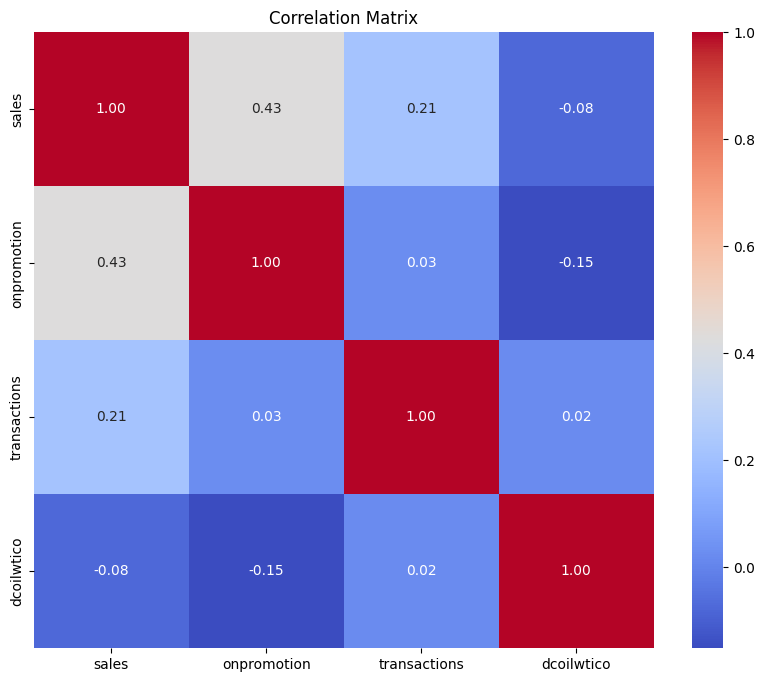

In [ ]:
# correlation matrix to understand how sales, onpromotion, transactions and oil price are correlated.
# Selecting relevant columns
columns = ['sales', 'onpromotion','transactions', 'dcoilwtico']

# Creating a correlation matrix
correlation_matrix = train_df[columns].corr()

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

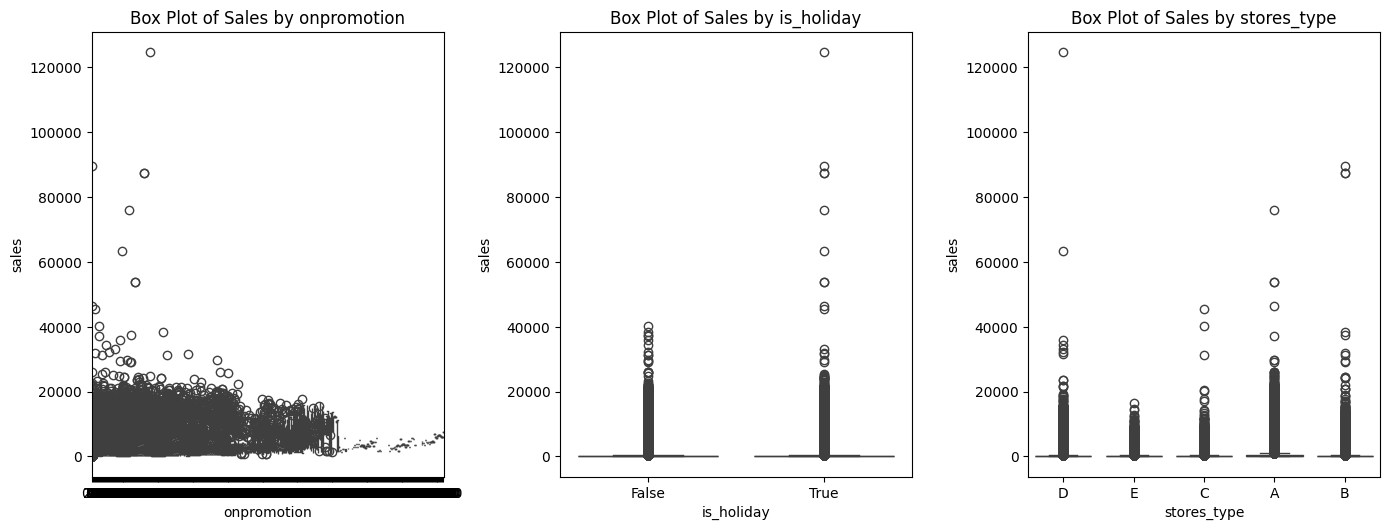

In [ ]:
# explore the distribution of sales across selected columns
# Selecting relevant columns
selected_columns = ['onpromotion', 'is_holiday', 'stores_type']

# Creating box plots
plt.figure(figsize=(14, 10))
for i, column in enumerate(selected_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=column, y='sales', data=train_df)
    plt.title(f'Box Plot of Sales by {column}')
plt.tight_layout()
plt.show()


Handling Missing Values

In [ ]:
# check for missing values
train_df.isnull().sum()

id                    4
date                  0
store_nbr             4
family                4
sales                 4
onpromotion           4
dcoilwtico       867835
city                  4
state                 4
stores_type           4
cluster               4
transactions     247174
holiday_type    2551824
is_holiday            0
dtype: int64

Note: 

1. The 'bfill' method will be used to handle missing values in the 'dcoilwtico' column.
2. The NaN values in the 'transaction' column will be handled using the median imputation due to the skewness of the data.
3. The NaN values in the holiday_type signifies non-holiday days and therefore will be filled by replacing with 'No_holiday'
4. The missing values in the columns (id, store_type, store_nbr, family, sales, onpromotion, city, state, and cluster) are related to specific dates ('2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25') that were added to the dataset. In order to leaverage the temporal order of the dataset whose nature is time-dependent, the 'bfill' method will be used to fill in these missing values. 

In [ ]:
# Using the back fill to handle NaN values
train_df['dcoilwtico'].fillna(method='bfill', inplace=True)

In [ ]:
# Calculate the median of the transactions column
median_transactions = train_df['transactions'].median()

# Impute missing values with the median
train_df['transactions'].fillna(median_transactions, inplace=True)

In [ ]:
# Fill missing values in 'holiday_type' column with 'no_holiday'
train_df['holiday_type'] = train_df['holiday_type'].fillna('no_holiday')

In [ ]:
columns_to_fill = ['id', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state', 'stores_type', 'cluster']

# Apply bfill to specified columns
train_df[columns_to_fill] = train_df[columns_to_fill].bfill()

In [ ]:
# Verify changes by checking for missing values
train_df.isnull().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
dcoilwtico      0
city            0
state           0
stores_type     0
cluster         0
transactions    0
holiday_type    0
is_holiday      0
dtype: int64

### Stationarity Testing (KPSS)

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import kpss

# Extract time series data
time_series_data = train_df['sales']

# Define the KPSS test
def kpss_test(series):
    statistic, p_value, lags, critical_values = kpss(series)
    return {
        'statistic': statistic,
        'p_value': p_value,
        'num_lags': lags,
        'critical_values': critical_values
    }

# Perform the KPSS test
kpss_result = kpss_test(time_series_data)


# Extract the p-value from the result
p_value = kpss_result['p_value']

# Check the p-value against a significance level (e.g., 0.05)
if p_value <= 0.05:
    print("Reject the null hypothesis: The sales data is stationary.")
else:
    print("Fail to reject the null hypothesis: The sales data is non-stationary.")

Reject the null hypothesis: The sales data is stationary.


## Answering Business Questions

1.	What are the top 10 stores in terms of sales?

In [ ]:
# DataFrame containing merged data
top_stores_sales = train_df.groupby('store_nbr')['sales'].sum().sort_values(ascending=True).head(10).reset_index()

# Plotting with Plotly
fig = px.bar(top_stores_sales, x='store_nbr', y='sales',
             title='Top 10 Stores by Total Sales',
             labels={'sales': 'Total Sales', 'store_nbr': 'Store Number'},
             color='sales',
             color_continuous_scale='viridis')

# Customize layout
fig.update_layout(xaxis_title='Store Number', yaxis_title='Total Sales')

fig.show()


2.  What are the top 5 most frequently purchased product families?

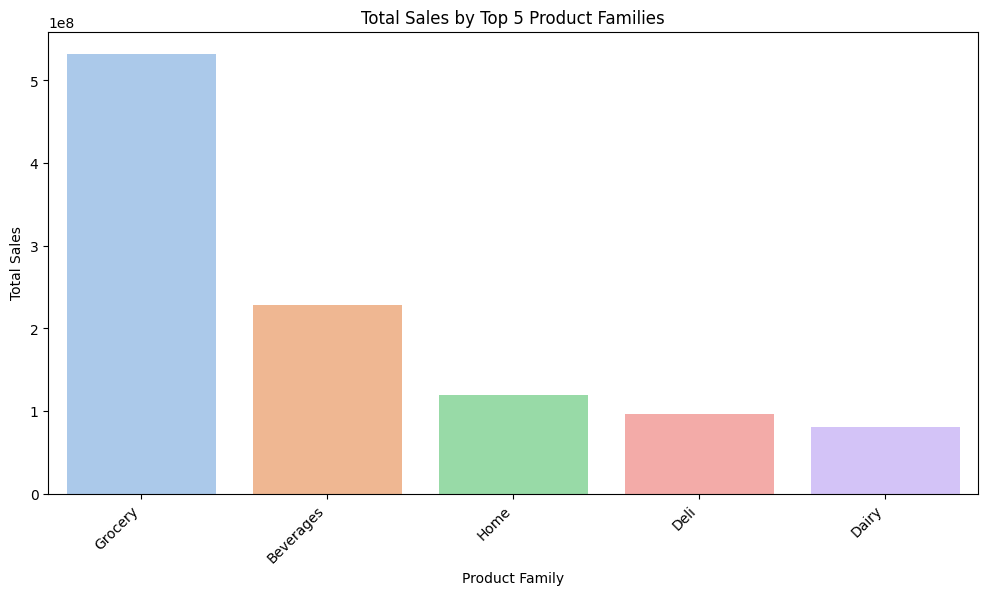

In [ ]:
top_family_sales = train_df.groupby('family')['sales'].sum().nlargest(5).reset_index()

# Define a color palette for the top 5 product families
colors = sns.color_palette('pastel')[:5]

# Plot bar chart with seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='family', y='sales', data=top_family_sales, palette=colors)
plt.title('Total Sales by Top 5 Product Families')
plt.xlabel('Product Family')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.show()


3.  Which dates have the lowest and highest sales for each year?

In [ ]:
# Extracting 'year' from the 'date' column
train_df['year'] = train_df['date'].dt.year

# Finding dates with lowest and highest sales for each year
lowest_sales_dates = train_df.loc[train_df.groupby('year')['sales'].idxmin()][['year', 'date', 'sales']]
highest_sales_dates = train_df.loc[train_df.groupby('year')['sales'].idxmax()][['year', 'date', 'sales']]

# Line plot for dates with lowest sales
fig_lowest = px.line(lowest_sales_dates, x='date', y='sales', color='year', markers=True,
                     title='Dates with Lowest Sales for Each Year', labels={'sales': 'Sales', 'date': 'Date'})

# Line plot for dates with highest sales
fig_highest = px.line(highest_sales_dates, x='date', y='sales', color='year', markers=True,
                      title='Dates with Highest Sales for Each Year', labels={'sales': 'Sales', 'date': 'Date'})

# Show the plots
fig_lowest.show()
fig_highest.show()

4.  Did the 2016 earthquake have a noticeable impact on sales?

In [ ]:

earthquake_start_date = '2016-04-16'
earthquake_end_date = '2016-04-17'

# Filter data for the defined period around the earthquake
earthquake_data = train_df[(train_df['date'] >= earthquake_start_date) & (train_df['date'] <= earthquake_end_date)]

# Aggregate sales data
overall_sales = train_df.groupby('date')['sales'].sum().reset_index(name='Overall Sales')
earthquake_sales = earthquake_data.groupby('date')['sales'].sum().reset_index(name='Sales Around Earthquake')

# Combine the two datasets for plotting
combined_data = overall_sales.merge(earthquake_sales, on='date', how='left')

# Plotly Line Chart
fig = px.line(combined_data, x='date', y=['Overall Sales', 'Sales Around Earthquake'], title='Sales Trends Around the 2016 Earthquake',
              labels={'value': 'Total Sales', 'variable': 'Sales Category'},
              line_shape='linear', render_mode='svg')

# Add earthquake annotation
fig.add_shape(
    dict(
        type="line",
        x0=earthquake_start_date,
        y0=0,
        x1=earthquake_start_date,
        y1=combined_data['Overall Sales'].max(),
        line=dict(color="red", width=2, dash="dash"),
    )
)

fig.update_layout(xaxis_title='Date', yaxis_title='Total Sales', legend_title='Sales Category')

# Show the interactive plot
fig.show()

5. Is there a noticeable correlation between promotions and sales?

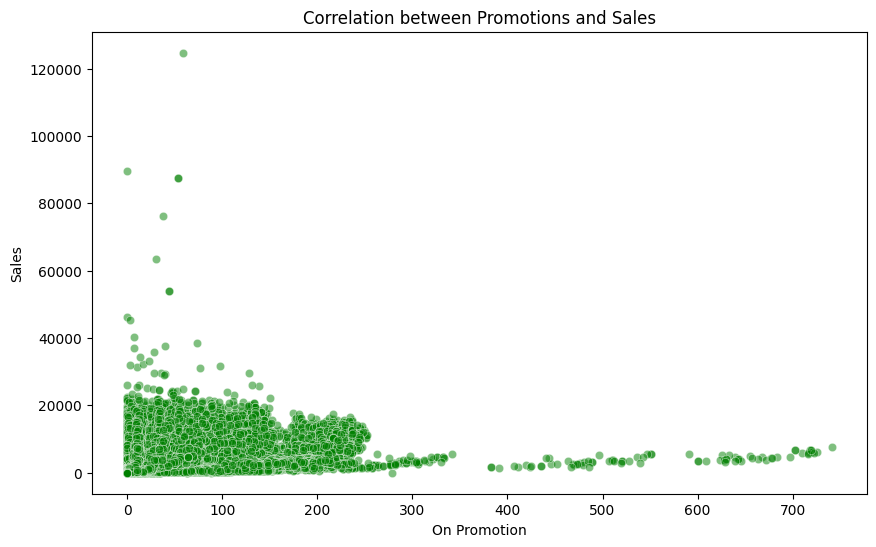

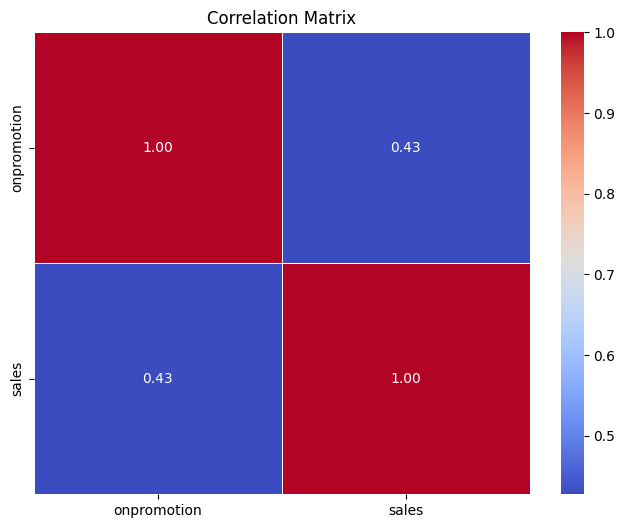

In [ ]:
# Scatter plot for promotions and sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='onpromotion', y='sales', data=train_df, color='green', alpha=0.5)
plt.title('Correlation between Promotions and Sales')
plt.xlabel('On Promotion')
plt.ylabel('Sales')
plt.show()

# Correlation matrix
correlation_matrix = train_df[['onpromotion', 'sales']].corr()

# Display correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

* Insight:

The correlation coefficient of 0.43 signifies a moderate positive correlation between sales and onpromotion. This implies that an increase in one variable tends to be associated with a corresponding increase in the other. The positive correlation suggests a tendency for higher sales during promotional periods (onpromotion=1), indicating a moderately heightened likelihood of increased sales. However, the moderate strength (0.43) indicates that, although there is a discernible relationship between promotions and sales, other influencing factors may contribute to sales variations.

## Hypothesis Testing

In [ ]:
# Split the data into sales during promotional periods and sales during non-promotional periods
promotional_sales = train_df[train_df['onpromotion'] == 1]['sales']
non_promotional_sales = train_df[train_df['onpromotion'] == 0]['sales']

# Hypothesis testing (t-test)
t_stat, p_value = stats.ttest_ind(promotional_sales, non_promotional_sales, equal_var=False)

# Display results
print("\nT-Test Results:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value:.3f}")  # Format p-value to 3 decimal places

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("\nReject the null hypothesis. There is a significant impact on store sales during promotional periods.")
else:
    print("\nFail to reject the null hypothesis. There is no significant impact on store sales during promotional periods.")



T-Test Results:
T-statistic: 131.77404995170204
P-value: 0.000

Reject the null hypothesis. There is a significant impact on store sales during promotional periods.


* Insights:

There is a statistically significant difference in sales between promotional and non-promotional periods, and this difference is not likely due to random chance as evidence from the data suggests that promotional periods have a meaningful effect on store sales.

## Feature Processing/Engineering

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3024058 entries, 0 to 3054351
Data columns (total 15 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            float64       
 1   date          datetime64[ns]
 2   store_nbr     float64       
 3   family        object        
 4   sales         float64       
 5   onpromotion   float64       
 6   dcoilwtico    float64       
 7   city          object        
 8   state         object        
 9   stores_type   object        
 10  cluster       float64       
 11  transactions  float64       
 12  holiday_type  object        
 13  is_holiday    bool          
 14  year          int32         
dtypes: bool(1), datetime64[ns](1), float64(7), int32(1), object(5)
memory usage: 401.9+ MB


In [ ]:
# Extract additional features from the 'date' column

# Month
train_df['month'] = train_df['date'].dt.month

# Day of the Week (Monday=0, Sunday=6)
train_df['day_of_week'] = train_df['date'].dt.dayofweek

# Day of the Month
train_df['day_of_month'] = train_df['date'].dt.day

# Quarter
train_df['quarter'] = train_df['date'].dt.quarter

# Verify changes
train_df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,stores_type,cluster,transactions,holiday_type,is_holiday,year,month,day_of_week,day_of_month,quarter
0,0.0,2013-01-01,1.0,Automotive,0.0,0.0,93.139999,Quito,Pichincha,D,13.0,1395.0,Holiday,True,2013,1,1,1,1
1,1194.0,2013-01-01,42.0,Beverages,0.0,0.0,93.139999,Cuenca,Azuay,D,2.0,1395.0,Holiday,True,2013,1,1,1,1
2,1193.0,2013-01-01,42.0,Grocery,0.0,0.0,93.139999,Cuenca,Azuay,D,2.0,1395.0,Holiday,True,2013,1,1,1,1
3,1192.0,2013-01-01,42.0,Books,0.0,0.0,93.139999,Cuenca,Azuay,D,2.0,1395.0,Holiday,True,2013,1,1,1,1
4,1191.0,2013-01-01,42.0,Beverages,0.0,0.0,93.139999,Cuenca,Azuay,D,2.0,1395.0,Holiday,True,2013,1,1,1,1


In [ ]:
# Drop the 'holiday_type, stores_type' and the 'id' column
train_df.drop('holiday_type', axis=1, inplace=True)
train_df.drop('stores_type', axis=1, inplace=True)
train_df.drop('id', axis=1, inplace=True)

# Set 'date' column as the index
train_df.set_index('date', inplace=True)

# Verify changes
train_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3024058 entries, 2013-01-01 to 2017-08-15
Data columns (total 15 columns):
 #   Column        Dtype  
---  ------        -----  
 0   store_nbr     float64
 1   family        object 
 2   sales         float64
 3   onpromotion   float64
 4   dcoilwtico    float64
 5   city          object 
 6   state         object 
 7   cluster       float64
 8   transactions  float64
 9   is_holiday    bool   
 10  year          int32  
 11  month         int32  
 12  day_of_week   int32  
 13  day_of_month  int32  
 14  quarter       int32  
dtypes: bool(1), float64(6), int32(5), object(3)
memory usage: 291.3+ MB


In [ ]:
from sklearn.preprocessing import StandardScaler

# Scaling Numeric Variables (Min-Max Scaling)
# create an instance of StandardScaler
scaler = StandardScaler()

# select numerical columns
num_cols = ['sales', 'transactions', 'dcoilwtico']

# fit and transform the numerical columns
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])

# Display the updated dataframe
train_df.head()

,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,cluster,transactions,is_holiday,year,month,day_of_week,day_of_month,quarter
date,,,,,,,,,,,,,,,
2013-01-01,1.0,Automotive,-0.324172,0.0,0.986011,Quito,Pichincha,13.0,-0.298486,True,2013,1,1,1,1
2013-01-01,42.0,Beverages,-0.324172,0.0,0.986011,Cuenca,Azuay,2.0,-0.298486,True,2013,1,1,1,1
2013-01-01,42.0,Grocery,-0.324172,0.0,0.986011,Cuenca,Azuay,2.0,-0.298486,True,2013,1,1,1,1
2013-01-01,42.0,Books,-0.324172,0.0,0.986011,Cuenca,Azuay,2.0,-0.298486,True,2013,1,1,1,1
2013-01-01,42.0,Beverages,-0.324172,0.0,0.986011,Cuenca,Azuay,2.0,-0.298486,True,2013,1,1,1,1


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Define the categorical columns to encode
categorical_columns = ["family", "city", "state"]

# Perform one-hot encoding
encoder = OneHotEncoder()
one_hot_encoded_data = encoder.fit_transform(train_df[categorical_columns])

# Create column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Convert the one-hot encoded data to a DataFrame
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)

# Concatenate the original dataframe with the one-hot encoded data
train_df_encoded = pd.concat([train_df.reset_index(drop=True), one_hot_encoded_df], axis=1)

# Drop the original categorical columns
train_df_encoded.drop(categorical_columns, axis=1, inplace=True)

# Print the head of the encoded DataFrame
train_df_encoded.head()


,store_nbr,sales,onpromotion,dcoilwtico,cluster,transactions,is_holiday,year,month,day_of_week,...,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua
0,1.0,-0.324172,0.0,0.986011,13.0,-0.298486,True,2013,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,42.0,-0.324172,0.0,0.986011,2.0,-0.298486,True,2013,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,42.0,-0.324172,0.0,0.986011,2.0,-0.298486,True,2013,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,42.0,-0.324172,0.0,0.986011,2.0,-0.298486,True,2013,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,42.0,-0.324172,0.0,0.986011,2.0,-0.298486,True,2013,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data Splitting

In [ ]:
train_set = train_df_encoded.loc[train_df_encoded['year'].isin([2013, 2014, 2015, 2016])]
eval_set = train_df_encoded.loc[train_df_encoded['year'] == 2017]

In [ ]:
# preview the shape
train_set.shape

(2619544, 61)

In [ ]:
# preview the shape
eval_set.shape

(404514, 61)

In [ ]:
# Separate the target variable and features for training and testing
X_train = train_set.drop('sales', axis=1)
y_train = train_set['sales'] 


X_eval = eval_set.drop('sales', axis=1)  
y_eval = eval_set['sales']

In [ ]:
# Initialize the results dataframe
results_df = pd.DataFrame(columns=['Model', 'RMSLE', 'RMSE', 'MSE', 'MAE'])

### MODELS

#### Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error

# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_predictions = linear_model.predict(X_eval)

# Calculate metrics
linear_mse = mean_squared_error(y_eval, linear_predictions)
linear_mae = mean_absolute_error(y_eval, linear_predictions)

# Apply the absolute value function to both y_eval and lr_predictions
y_eval_abs = abs(y_eval)
linear_predictions_abs = abs(linear_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
linear_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, linear_predictions_abs))

# Create a DataFrame to store results for Linear Regression
linear_results = pd.DataFrame({'Model': ['Linear Regression'],
                            'RMSLE': [linear_rmsle],
                            'RMSE': [np.sqrt(linear_mse)],
                            'MSE': [linear_mse],
                            'MAE': [linear_mae]}).round(2)

# Print the linear_results dataframe
print(linear_results)

               Model  RMSLE  RMSE   MSE   MAE
0  Linear Regression   0.26  0.94  0.88  0.43


#### XGBoost Model

In [ ]:
from xgboost import XGBRegressor

# XGBoost Regression Model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_eval)

# Calculate metrics
xgb_mse = mean_squared_error(y_eval, xgb_predictions)
xgb_mae = mean_absolute_error(y_eval, xgb_predictions)

# Apply the absolute value function to both y_eval and xgb_predictions
xgb_predictions_abs = abs(xgb_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
xgb_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, xgb_predictions_abs))

# Create a DataFrame to store results for XGBoost
xgb_results = pd.DataFrame({'Model': ['XGBoost Regression'],
                            'RMSLE': [xgb_rmsle],
                            'RMSE': [np.sqrt(xgb_mse)],
                            'MSE': [xgb_mse],
                            'MAE': [xgb_mae]}).round(2)

# Print the results
print(xgb_results)

                Model  RMSLE  RMSE   MSE   MAE
0  XGBoost Regression   0.22  0.62  0.39  0.26


#### CATBoost Model

In [ ]:
from catboost import CatBoostRegressor

# CatBoost Regression Model
catboost_model = CatBoostRegressor(iterations=100, random_state=42)
catboost_model.fit(X_train, y_train)
catboost_predictions = catboost_model.predict(X_eval)

# Calculate metrics
catboost_mse = mean_squared_error(y_eval, catboost_predictions)
catboost_mae = mean_absolute_error(y_eval, catboost_predictions)

# Apply the absolute value function to both y_eval and catboost_predictions
catboost_predictions_abs = abs(catboost_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
catboost_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, catboost_predictions_abs))

# Create a DataFrame to store results for CatBoost
catboost_results = pd.DataFrame({'Model': ['CatBoost Regression'],
                                 'RMSLE': [catboost_rmsle],
                                 'RMSE': [np.sqrt(catboost_mse)],
                                 'MSE': [catboost_mse],
                                 'MAE': [catboost_mae]}).round(2)

# Print the results
print(catboost_results)

Learning rate set to 0.5
0:	learn: 0.7831749	total: 357ms	remaining: 35.3s
1:	learn: 0.7145391	total: 664ms	remaining: 32.5s
2:	learn: 0.6898665	total: 995ms	remaining: 32.2s
3:	learn: 0.6759559	total: 1.33s	remaining: 32.1s
4:	learn: 0.6696537	total: 1.7s	remaining: 32.3s
5:	learn: 0.6657938	total: 2.03s	remaining: 31.9s
6:	learn: 0.6605963	total: 2.73s	remaining: 36.2s
7:	learn: 0.6591690	total: 3.48s	remaining: 40s
8:	learn: 0.6568597	total: 4.08s	remaining: 41.3s
9:	learn: 0.6528835	total: 4.43s	remaining: 39.9s
10:	learn: 0.6504062	total: 4.77s	remaining: 38.6s
11:	learn: 0.6483255	total: 5.09s	remaining: 37.4s
12:	learn: 0.6464628	total: 5.43s	remaining: 36.3s
13:	learn: 0.6446366	total: 5.78s	remaining: 35.5s
14:	learn: 0.6424850	total: 6.16s	remaining: 34.9s
15:	learn: 0.6410005	total: 6.48s	remaining: 34s
16:	learn: 0.6396056	total: 6.82s	remaining: 33.3s
17:	learn: 0.6386651	total: 7.17s	remaining: 32.6s
18:	learn: 0.6372669	total: 7.52s	remaining: 32.1s
19:	learn: 0.6364266	

#### Gradient Boosting Regression Model

In [ ]:
# Gradient Boosting Regression Model
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr_model.fit(X_train, y_train)
gbr_predictions = gbr_model.predict(X_eval)

# Calculate metrics
gbr_mse = mean_squared_error(y_eval, gbr_predictions)
gbr_mae = mean_absolute_error(y_eval, gbr_predictions)

# Apply the absolute value function to both y_eval and gb_predictions
y_eval_abs = abs(y_eval)
gbr_predictions_abs = abs(gbr_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
gbr_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, gbr_predictions_abs))

# Create a DataFrame to store results for Gradient Boosting
gbr_results = pd.DataFrame({'Model': ['Gradient Boosting Regression'],
                            'RMSLE': [gbr_rmsle],
                            'RMSE': [np.sqrt(gbr_mse)],
                            'MSE': [gbr_mse],
                            'MAE': [gbr_mae]}).round(2)

# Print the results_gb dataframe
gbr_results

,Model,RMSLE,RMSE,MSE,MAE
0,Gradient Boosting Regression,0.24,0.68,0.46,0.31


#### ARIMA Model

In [ ]:
y_train = train_set['sales']

# d and q are equal to zero as data is already stationary
p = 1
d = 0
q = 0  

# Create an instance of the ARIMA model
arima_model = ARIMA(y_train, order=(p, d, q))

# Fit the model to the training data
arima_model_fit = arima_model.fit()

# Make predictions on the evaluation data
arima_predictions = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(X_eval) - 1)

# Calculate evaluation metrics
arima_mse = mean_squared_error(y_eval, arima_predictions)
arima_rmse = np.sqrt(arima_mse)

# Apply the absolute value function to y_eval to remove negative signs
y_eval_abs = abs(y_eval)
arima_predictions_abs = abs(arima_predictions)

# Calculate the Mean Absolute Error (MAE)
arima_mae = mean_absolute_error(y_eval, arima_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
arima_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, arima_predictions_abs))

# Create a DataFrame to store results for ARIMA
arima_results = pd.DataFrame({'Model': ['ARIMA'],
                            'RMSLE': [arima_rmsle],
                            'RMSE': [np.sqrt(arima_mse)],
                            'MSE': [arima_mse],
                            'MAE': [arima_mae]}).round(2)

# Print the results_arima dataframe
arima_results

,Model,RMSLE,RMSE,MSE,MAE
0,ARIMA,0.47,1.23,1.52,0.53


#### SARIMA Model

In [ ]:
# Set the order and seasonal order parameters
# Seasonal autoregressive order
P = 0  
# Seasonal differencing order
D = 0  
# Seasonal moving average order
Q = 0  
# Number of time steps in each season (chosen based on the number of months each year)
s = 12  

# Select only a subset of rows for training (adjust the number as needed). This was done due to limited computational resources
subset_size = 100000
X_train_subset = X_train.head(subset_size)
y_train_subset = y_train.head(subset_size)

# Select only numeric columns from X_train_subset
numeric_columns = X_train_subset.select_dtypes(include=['float64']).columns
X_train_numeric = X_train_subset[numeric_columns]

# Create an instance of the SARIMA model
sarima_model = SARIMAX(endog=y_train_subset, exog=X_train_numeric, order=(p, d, q), seasonal_order=(P, D, Q, s))

# Fit the model to the training data
sarima_fit = sarima_model.fit()

# Select only numeric columns from X_eval
X_eval_numeric = X_eval[numeric_columns]

# Make predictions on the evaluation data
sarima_predictions = sarima_fit.forecast(steps=len(y_eval), exog=X_eval_numeric)

# Calculate metrics
sarima_mse = mean_squared_error(y_eval, sarima_predictions)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mae = mean_absolute_error(y_eval, sarima_predictions)
sarima_rmsle = np.sqrt(mean_squared_error(np.log1p(y_eval), np.log1p(sarima_predictions)))

# Create a DataFrame to store results for SARIMA
sarima_results = pd.DataFrame({'Model': ['SARIMA'],
                                'RMSLE': [sarima_rmsle],
                                'RMSE': [sarima_rmse],
                                'MSE': [sarima_mse],
                                'MAE': [sarima_mae]}).round(2)

# Print the results_sarima dataframe
sarima_results


,Model,RMSLE,RMSE,MSE,MAE
0,SARIMA,0.46,1.17,1.37,0.45


#### Decision Tree Model

In [ ]:
from sklearn.tree import DecisionTreeRegressor
# Decision Tree Regression Model
decision_model = DecisionTreeRegressor()
decision_model.fit(X_train, y_train)
decision_predictions = decision_model.predict(X_eval)
# Create results dataframe
# results_df = pd.DataFrame(columns=['Model', 'RMSLE', 'RMSE', 'MSE', 'MAE'])
 
# Calculate metrics
decision_mse = mean_squared_error(y_eval, decision_predictions)
decision_mae = mean_absolute_error(y_eval, decision_predictions)
 
# Apply the absolute value function to both y_eval and dt_predictions
y_eval_abs = abs(y_eval)
decision_predictions_abs = abs(decision_predictions)
 
# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
decision_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, decision_predictions_abs))
 
# Create a DataFrame to store results for Decision Tree model
decision_results = pd.DataFrame({'Model': ['Decision Tree'],
                            'RMSLE': [decision_rmsle],
                            'RMSE': [np.sqrt(decision_mse)],
                            'MSE': [decision_mse],
                            'MAE': [decision_mae]}).round(2)
 
# Print the results_lr dataframe
decision_results

,Model,RMSLE,RMSE,MSE,MAE
0,Decision Tree,0.28,0.99,0.98,0.3


### Results

In [ ]:
# List of DataFrames to concatenate
dfs = [linear_results, xgb_results, catboost_results, gbr_results, arima_results, sarima_results]

# Concatenate all results into a single DataFrame
results_df = pd.concat(dfs, ignore_index=True)

# Sort the results_df based on RMSLE in ascending order
results_df = results_df.sort_values(by='RMSLE', ascending=True)

# Reset the index of the DataFrame
results_df = results_df.reset_index(drop=True)

# Print the final results DataFrame
print(results_df)

                          Model  RMSLE  RMSE   MSE   MAE
0            XGBoost Regression   0.22  0.62  0.39  0.26
1           CatBoost Regression   0.22  0.62  0.39  0.26
2  Gradient Boosting Regression   0.24  0.68  0.46  0.31
3             Linear Regression   0.26  0.94  0.88  0.43
4                        SARIMA   0.46  1.17  1.37  0.45
5                         ARIMA   0.47  1.23  1.52  0.53


* Summary:

The models "XGBoost Regression" and "CatBoost Regression" demonstrate superior performance based on the RMSLE metric. This metric, known for assigning less significance to larger errors, enhances robustness against outliers. Given the considerable variation in sales across diverse regions, stores, and items in our scenario, the RMSLE metric emerges as a more suitable measure for evaluating model accuracy.

### Hyperparameter Tuning

#### CatBoost Model

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
import pandas as pd
import numpy as np

# Split the data into a smaller training set and an evaluation set
X_small, _, y_small, _ = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Further split the smaller training set into an actual training set and a validation set
X_train_small, X_eval, y_train_small, y_eval = train_test_split(X_small, y_small, test_size=0.2, random_state=42)

# Define the parameter grid for randomized search
param_dist = {
    'n_estimators': [300, 350, 400],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [7, 8, 9],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bylevel': [0.6, 0.7, 0.8],
}

# Create a CatBoost model
catboost_model = CatBoostRegressor(random_state=42)

# Instantiate RandomizedSearchCV with reduced n_iter and changed n_jobs
random_search = RandomizedSearchCV(catboost_model, param_dist, n_iter=7, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the random search to the smaller training set
random_search.fit(X_train_small, y_train_small)

# Get the best parameters and the best model
best_params = random_search.best_params_
best_catboost_model = random_search.best_estimator_

# Make predictions on the evaluation set
tuned_catboost_predictions = best_catboost_model.predict(X_eval)

# Calculate metrics
tuned_catboost_mse = mean_squared_error(y_eval, tuned_catboost_predictions)
tuned_catboost_mae = mean_absolute_error(y_eval, tuned_catboost_predictions)

# Apply the absolute value function to both y_eval and catboost_predictions
tuned_catboost_predictions_abs = abs(tuned_catboost_predictions)
y_eval_abs = abs(y_eval)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
tuned_catboost_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, tuned_catboost_predictions_abs))

# Create a DataFrame to store results for tuned CatBoost
tuned_catboost_results = pd.DataFrame({'Model': ['Tuned Catboost Regression'],
                                   'RMSLE': [tuned_catboost_rmsle],
                                   'RMSE': [np.sqrt(tuned_catboost_mse)],
                                   'MSE': [tuned_catboost_mse],
                                   'MAE': [tuned_catboost_mae]}).round(2)

# Print the results
print(tuned_catboost_results)
print("Best Hyperparameters:", best_params)
